# Chess Game Analysis: Building My First ML Pipeline

**Course:** CS156 - Machine Learning Pipeline Assignment 1  
**Date:** February 2026

---

## Why Chess?

I don't want to just do an assignment and get grades. I want to go through my process of learning through something I really love and care about.

**I love chess.** I've been playing it on and off since childhood, and it's one of those things that has stayed with me through different phases of my life. Recently, I've noticed something frustrating: my progress has stalled. I'm not improving like I used to, and my rating seems stuck. That got me thinking—what if I could use machine learning to actually understand my own play and find ways to improve?

So for this assignment, I decided to build my first ML pipeline about something that genuinely matters to me: my chess journey. I want a model that can help me improve my performance and increase my ratings.

I've collected data from three different accounts across my life:

| Era | Platform | Account | Games | Rating |
|-----|----------|---------|-------|--------|
| Childhood | Chess.com | Abdulrahmansoli | 1,013 | ~700-815 |
| High School | Lichess | Abdulrahmansoli | 259 | ~1,300-1,578 |
| Present | Chess.com | AbdulrahmanSoliman2 | 169 | ~1,000-1,200 |

## The Models I Want to Build

Since I want to actually improve at chess, I've thought about what models would be most useful. Here's my plan:

### Main Models (Deep Focus)

These are the ones I want to explore thoroughly:

1. **Outcome Prediction from First X Moves + Context** - Can I predict if I'll win or lose based on how the opening goes and the game context? This could help me understand which openings and early patterns lead to success for me.

2. **Tilt Detection Model** - Do I play worse after losing? Is there a pattern to when I go on tilt? If I can detect this, I can learn when to take breaks.

3. **Engine-Based Early Blunder Model** - Using engine analysis, can I predict when I'm likely to make a blunder early in the game? What conditions lead to my mistakes?

### Smaller Analysis Modules (For Later)

These are quick but potentially valuable analyses I might explore if I have time:

- **Color Effect** - Do I perform differently as White vs Black? A controlled expected-score analysis.
- **Time-of-Day Effect** - When do I play best? Using cyclic features and confidence bands.
- **Opening Recommender** - Which openings should I focus on? (Bucketing openings by type)

*I'm honestly not 100% sure about the smaller models yet—I'll see how the main ones go first.*

## What This Notebook Covers

This notebook handles the **data ingestion, cleaning, and feature engineering** that I'll need for any of these models. The preprocessing is model-agnostic—once I have clean features extracted from my games, I can plug them into whatever model makes sense.

---

In [66]:
import os, re, warnings
from datetime import datetime
import chess
import chess.pgn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

## Section 2: Data Ingestion

### Getting My Game Data

I needed to collect all my chess games from different platforms. Here's how I did it:

**Chess.com**: I wrote a Python script to download my games automatically using their public API. You can find it here: [`download_chess_pgn.py`](https://github.com/Abdulrahmansoliman/Chess-ML-pipeline/blob/main/download_chess_pgn.py)

**Lichess**: Their API is straightforward - just download and go.

**About PGN Format**: All chess games are stored in PGN (Portable Game Notation). Each game has:
- **Headers**: Player names, ratings, date, time control, result
- **Moves**: The actual moves in algebraic notation (e.g., `e4 e5 Nf3 Nc6...`)

I like to keep my code organized, so I'm using classes to handle the data loading.

In [67]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any


@dataclass
class ChessAccount:
    """
    Represents a chess account with its metadata.
    
    Attributes:
        account_id: Unique identifier for the account
        era: The period of my life (childhood, highschool, present)
        platform: Chess platform (chesscom, lichess)
        username: My username on the platform
        pgn_path: Path to the PGN file containing games
    """
    account_id: str
    era: str
    platform: str
    username: str
    pgn_path: str


# My chess accounts across different eras
# Chess.com data downloaded using: https://github.com/Abdulrahmansoliman/Chess-ML-pipeline/blob/main/download_chess_pgn.py
ACCOUNTS = [
    ChessAccount("childhood", "childhood", "chesscom", "Abdulrahmansoli", 
                 "PGN-data/chess_com_childhood_abdulrahmansoli.pgn"),
    ChessAccount("highschool", "highschool", "lichess", "Abdulrahmansoli", 
                 "PGN-data/lichess_Abdulrahmansoli_2026-02-12.pgn"),
    ChessAccount("present", "present", "chesscom", "AbdulrahmanSoliman2", 
                 "PGN-data/chess_com_current_abdulrahmansoliman2.pgn")
]

print(f"Configured {len(ACCOUNTS)} accounts")
for acc in ACCOUNTS:
    print(f"  - {acc.era}: {acc.username} ({acc.platform})")

Configured 3 accounts
  - childhood: Abdulrahmansoli (chesscom)
  - highschool: Abdulrahmansoli (lichess)
  - present: AbdulrahmanSoliman2 (chesscom)


In [68]:
class PGNParser:
    """
    Utility class for parsing PGN game data.
    Contains static methods for parsing game results, time controls, and dates.
    """
    
    @staticmethod
    def get_outcome(result: str, my_color: str) -> Optional[str]:
        """
        Determine the game outcome from my perspective.
        
        Args:
            result: Game result string (e.g., '1-0', '0-1', '1/2-1/2')
            my_color: The color I played ('white' or 'black')
            
        Returns:
            'win', 'loss', 'draw', or None if result is invalid
        """
        if result not in {'1-0', '0-1', '1/2-1/2'}:
            return None
        if result == '1/2-1/2':
            return 'draw'
        if (result == '1-0' and my_color == 'white') or (result == '0-1' and my_color == 'black'):
            return 'win'
        return 'loss'
    
    @staticmethod
    def parse_time_control(tc: str) -> tuple:
        """
        Parse time control string into base time and increment.
        
        Args:
            tc: Time control string (e.g., '300+5', '600')
            
        Returns:
            Tuple of (base_seconds, increment_seconds) or (None, None) if invalid
        """
        if not tc or tc in {'-', '?'}:
            return (None, None)
        
        # Format: base+increment (e.g., '300+5')
        match = re.match(r'^(\d+)\+(\d+)$', tc)
        if match:
            return int(match.group(1)), int(match.group(2))
        
        # Format: base only (e.g., '600')
        match = re.match(r'^(\d+)$', tc)
        if match:
            return int(match.group(1)), 0
        
        return (None, None)
    
    @staticmethod
    def parse_datetime(headers: dict) -> Optional[datetime]:
        """
        Extract datetime from PGN headers.
        
        Args:
            headers: Dictionary of PGN headers
            
        Returns:
            datetime object or None if parsing fails
        """
        date_str = headers.get('UTCDate') or headers.get('Date')
        time_str = headers.get('UTCTime') or headers.get('Time')
        
        if not date_str or date_str in {'????.??.??'}:
            return None
        
        try:
            if time_str and time_str not in {'??:??:??'}:
                return datetime.strptime(f'{date_str} {time_str}', '%Y.%m.%d %H:%M:%S')
            return datetime.strptime(date_str, '%Y.%m.%d')
        except ValueError:
            return None
    
    @staticmethod
    def safe_int(value) -> Optional[int]:
        """Safely convert a value to int, returning None on failure."""
        try:
            return int(value)
        except (ValueError, TypeError):
            return None



In [69]:
class PGNLoader:
    """
    Loads and parses chess games from PGN files.
    
    This class handles reading PGN files and extracting game data
    into a structured format for analysis.
    """
    
    def __init__(self, account: ChessAccount):
        """
        Initialize the loader with a chess account.
        
        Args:
            account: ChessAccount object containing account metadata
        """
        self.account = account
        self.parser = PGNParser()
    
    def load_games(self) -> pd.DataFrame:
        """
        Load all games from the PGN file.
        
        Returns:
            DataFrame with parsed game data
        """
        games = []
        username_lower = self.account.username.lower()
        
        with open(self.account.pgn_path, 'r', encoding='utf-8', errors='ignore') as f:
            while True:
                game = chess.pgn.read_game(f)
                if game is None:
                    break
                
                game_data = self._parse_game(game, username_lower)
                if game_data:
                    games.append(game_data)
        
        return pd.DataFrame(games)
    
    def _parse_game(self, game, username_lower: str) -> Optional[Dict[str, Any]]:
        """
        Parse a single game into a dictionary.
        
        Args:
            game: Chess game object from python-chess
            username_lower: Lowercase username to identify my games
            
        Returns:
            Dictionary with game data or None if game should be skipped
        """
        headers = game.headers
        
        # Determine which color I played
        white = (headers.get('White') or '').lower()
        black = (headers.get('Black') or '').lower()
        
        if white == username_lower:
            my_color = 'white'
            my_elo = headers.get('WhiteElo')
            opp_elo = headers.get('BlackElo')
        elif black == username_lower:
            my_color = 'black'
            my_elo = headers.get('BlackElo')
            opp_elo = headers.get('WhiteElo')
        else:
            return None  # Not my game
        
        # Get game result from my perspective
        result = headers.get('Result', '')
        outcome = PGNParser.get_outcome(result, my_color)
        if outcome is None:
            return None  # Invalid result
        
        # Parse time control
        tc = headers.get('TimeControl')
        base_sec, inc_sec = PGNParser.parse_time_control(tc)
        
        # Get moves
        moves = list(game.mainline_moves())
        
        # Parse ratings
        my_elo_int = PGNParser.safe_int(my_elo)
        opp_elo_int = PGNParser.safe_int(opp_elo)
        rating_diff = (my_elo_int - opp_elo_int) if (my_elo_int and opp_elo_int) else None
        
        return {
            'account_id': self.account.account_id,
            'era': self.account.era,
            'platform': self.account.platform,
            'game_datetime': PGNParser.parse_datetime(headers),
            'me_color': my_color,
            'result_raw': result,
            'outcome_me': outcome,
            'time_control': tc,
            'base_sec': base_sec,
            'inc_sec': inc_sec,
            'me_elo': my_elo_int,
            'opp_elo': opp_elo_int,
            'rating_diff': rating_diff,
            'eco': headers.get('ECO'),
            'opening': headers.get('Opening'),
            'n_plies': len(moves),
            'moves_uci': ' '.join(m.uci() for m in moves)
        }


# Load games from all accounts
print("Loading PGN files...")
games_list = []

for account in ACCOUNTS:
    loader = PGNLoader(account)
    df = loader.load_games()
    print(f"  {account.era}: {len(df)} games")
    games_list.append(df)

df_games = pd.concat(games_list, ignore_index=True)

# Sort chronologically - important for time-series/tilt analysis
df_games = df_games.sort_values('game_datetime').reset_index(drop=True)

print(f"\nTotal: {len(df_games)} games")
df_games.head()

Loading PGN files...
  childhood: 1013 games
  highschool: 269 games
  present: 169 games

Total: 1451 games


,account_id,era,platform,game_datetime,me_color,result_raw,outcome_me,time_control,base_sec,inc_sec,me_elo,opp_elo,rating_diff,eco,opening,n_plies,moves_uci
0,childhood,childhood,chesscom,2019-07-17 11:55:15,white,0-1,loss,600,600.0,0.0,741,1152.0,-411.0,A00,None,34,e2e3 e7e5 f1e2 b8c6 a2a3 d7d5 b2b4 g8f6 b4b5 c...
1,childhood,childhood,chesscom,2019-07-17 11:59:52,black,1-0,loss,600,600.0,0.0,706,1154.0,-448.0,C00,None,27,e2e4 e7e6 g1f3 h7h6 b1c3 g7g5 h2h3 c7c6 f3h2 g...
2,childhood,childhood,chesscom,2019-07-17 12:04:32,black,1-0,loss,600,600.0,0.0,605,792.0,-187.0,C00,None,83,e2e4 e7e6 f2f4 d7d5 b1c3 c7c6 e4d5 c6d5 d1e2 d...
3,childhood,childhood,chesscom,2019-07-17 18:44:28,white,0-1,loss,600,600.0,0.0,522,717.0,-195.0,A00,None,54,e2e3 b7b6 d2d4 b8c6 d4d5 e7e6 d5c6 d7c6 f1d3 f...
4,childhood,childhood,chesscom,2019-07-17 19:05:43,white,1-0,win,600,600.0,0.0,614,553.0,61.0,A00,None,9,e2e3 c7c6 f1d3 d8b6 d1f3 b6c5 e1d1 c5c2 d1c2


---

## Section 3: Data Cleaning

### Why Filter Games?

Not all games are useful for analysis. I'm focusing on games that actually measure my chess thinking:

- **No bullet games** - Games under 3 minutes are just about moving fast, not thinking. I want to analyze games where I actually had time to think.
- **No early disconnects** - If someone disconnects after a few moves, there's nothing to learn.
- **Minimum game length** - Need at least 10 plies to extract any meaningful patterns.

I'm keeping **blitz (3-10 min)**, **rapid (10-30 min)**, and **classical (30+ min)** games.

In [ ]:
class DataCleaner:
    """
    Cleans chess game data for analysis.
    
    Filters out games that don't reflect real chess thinking:
    - Bullet games (too fast)
    - Early disconnects
    - Empty/incomplete games
    """
    
    # Minimum time control in seconds (3 minutes = 180 seconds)
    MIN_TIME_SECONDS = 180
    
    # Minimum game length in plies
    MIN_PLIES = 10
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize cleaner with raw game data.
        
        Args:
            df: DataFrame with raw chess games
        """
        self.df_raw = df
        self.df_clean = None
    
    def clean(self, verbose: bool = True) -> pd.DataFrame:
        """
        Apply all cleaning filters.
        
        Args:
            verbose: Print progress messages
            
        Returns:
            Cleaned DataFrame
        """
        if verbose:
            print(f"Starting with {len(self.df_raw)} games")
        
        df = self.df_raw.copy()
        
        # Remove bullet games - too fast for meaningful analysis
        df = df[df['base_sec'] >= self.MIN_TIME_SECONDS]
        if verbose:
            print(f"After removing bullet games: {len(df)} games")
        
        # Remove early disconnects
        df = df[df['n_plies'] >= self.MIN_PLIES]
        if verbose:
            print(f"After removing early disconnects: {len(df)} games")
        
        # Remove empty games
        df = df[df['moves_uci'].str.len() > 0]
        if verbose:
            print(f"After removing empty games: {len(df)} games")
        
        # Fix data types
        df['me_elo'] = df['me_elo'].astype('Int64')
        df['opp_elo'] = df['opp_elo'].astype('Int64')
        
        # Add time category
        df['time_category'] = df['base_sec'].apply(self._categorize_time)
        
        self.df_clean = df
        
        if verbose:
            print(f"\nFinal: {len(df)} games ready for analysis")
        
        return df
    
    @staticmethod
    def _categorize_time(base_sec) -> str:
        """
        Categorize game by time control.
        Note: Bullet games are already filtered out.
        """
        if base_sec is None:
            return 'unknown'
        if base_sec < 600:    # 3-10 minutes
            return 'blitz'
        if base_sec < 1800:   # 10-30 minutes
            return 'rapid'
        return 'classical'     # 30+ minutes


# Clean the data
cleaner = DataCleaner(df_games)
df_clean = cleaner.clean()

Starting with 1451 games
After removing bullet games: 1311 games
After removing early disconnects: 1250 games
After removing empty games: 1250 games

Final: 1250 games ready for analysis

--- Class Distribution ---
outcome_me
loss    704
win     502
draw     44
Name: count, dtype: int64


### Checking Class Balance Before Modeling

Although I have ~1.4k games, chess draws can still be relatively rare, which would create a severe class imbalance in a 3-class classifier and lead to unstable estimates and misleading accuracy.

Therefore, I check the class counts and, if the draw class is too small, I'll reformulate my first task as a **binary classification problem (win vs. not-win)** to ensure reliable training and evaluation.

In [75]:
# Check class balance
print("\n--- Class Distribution ---")
print(df_clean['outcome_me'].value_counts())


--- Class Distribution ---
outcome_me
loss    704
win     502
draw     44
Name: count, dtype: int64


In [ ]:
class FeatureExtractor:
    """
    Extracts features from chess games for ML modeling.
    
    Features are computed from the first N plies of each game,
    avoiding information leakage from the game outcome.
    
    Attributes:
        n_plies: Number of plies to analyze from game start
    """
    
    def __init__(self, n_plies: int = 20):
        """
        Initialize the feature extractor.
        
        Args:
            n_plies: Number of half-moves to analyze (default: 20 = ~10 full moves)
        """
        self.n_plies = n_plies
    
    def extract_game_features(self, moves_uci: str, me_color: str) -> Optional[Dict[str, Any]]:
        """
        Extract early-game behavior features from a single game.
        
        Args:
            moves_uci: Space-separated UCI moves string
            me_color: 'white' or 'black'
            
        Returns:
            Dictionary of features or None if game has invalid moves
        """
        try:
            board = chess.Board()
            moves = [chess.Move.from_uci(m) for m in moves_uci.split() if m]
            me_is_white = (me_color == 'white')
            
            # Binary features
            my_castled = 0
            opp_castled = 0
            my_queen_moved = 0
            
            # Count features
            my_pawn_moves = 0
            my_minor_moves = 0
            my_captures = 0
            my_checks = 0
            
            # Process first N plies
            for ply, move in enumerate(moves[:self.n_plies]):
                if move not in board.legal_moves:
                    return None
                
                is_my_turn = (board.turn == chess.WHITE) == me_is_white
                
                if is_my_turn:
                    piece_type = board.piece_type_at(move.from_square)
                    
                    # Binary features
                    if board.is_castling(move):
                        my_castled = 1
                    if piece_type == chess.QUEEN:
                        my_queen_moved = 1
                    
                    # Count features
                    if piece_type == chess.PAWN:
                        my_pawn_moves += 1
                    if piece_type in {chess.KNIGHT, chess.BISHOP}:
                        my_minor_moves += 1
                    if board.is_capture(move):
                        my_captures += 1
                    
                    board.push(move)
                    if board.is_check():
                        my_checks += 1
                else:
                    if board.is_castling(move):
                        opp_castled = 1
                    board.push(move)
            
            return {
                'my_castled_by_N': my_castled,
                'opp_castled_by_N': opp_castled,
                'my_queen_moved_by_N': my_queen_moved,
                'my_pawn_moves_N': my_pawn_moves,
                'my_minor_moves_N': my_minor_moves,
                'my_captures_N': my_captures,
                'my_checks_N': my_checks
            }
            
        except Exception:
            return None
    
    def extract_context_features(self, row: pd.Series) -> Dict[str, Any]:
        """
        Extract context features known before the game starts.
        
        Args:
            row: DataFrame row with game metadata
            
        Returns:
            Dictionary of context features
        """
        return {
            'rating_diff': row['rating_diff'] if pd.notna(row['rating_diff']) else 0,
            'base_sec': row['base_sec'] if pd.notna(row['base_sec']) else 0,
            'inc_sec': row['inc_sec'] if pd.notna(row['inc_sec']) else 0,
            'is_white': 1 if row['me_color'] == 'white' else 0
        }
    
    def transform(self, df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
        """
        Transform a DataFrame of games into a feature matrix.
        
        Args:
            df: DataFrame with columns: moves_uci, me_color, rating_diff, base_sec, inc_sec
            verbose: Print progress messages
            
        Returns:
            DataFrame with original data plus extracted features
        """
        if verbose:
            print(f"Extracting features from first {self.n_plies} plies...")
        
        feature_rows = []
        skipped = 0
        
        for idx, row in df.iterrows():
            game_features = self.extract_game_features(row['moves_uci'], row['me_color'])
            
            if game_features is None:
                skipped += 1
                continue
            
            context_features = self.extract_context_features(row)
            
            feature_rows.append({
                **row.to_dict(),
                **context_features,
                **game_features
            })
        
        df_features = pd.DataFrame(feature_rows)
        
        if verbose:
            print(f"Features extracted: {len(df_features)} games")
            if skipped > 0:
                print(f"Skipped {skipped} games with invalid moves")
        
        return df_features


# Extract features
extractor = FeatureExtractor(n_plies=20)
df_features = extractor.transform(df_clean)
df_features.head()

## Section 4: Feature Extraction — Design Choices

### What question does Model 1 answer?

Model 1 is **Outcome Prediction from First N Plies + Context**.

**Question:**
> Given what I know *before the game* (context) and what happens in the *first N plies*, what is the probability that I **win**?

**Output (binary version):**
- A probability $p(\text{win})$
- A decision: **win** vs **`not_win`** (where **`not_win = draw or loss`**)

Example:
> “Based on this start, $p(\text{win}) = 0.31$ → predicted: `not_win`.”

**Why binary first?** In my cleaned dataset (1250 games), draws are rare (44 total). A 3-class model (win/draw/loss) would have very few draw examples in each train/test split, which makes that class unstable. I can still try multiclass later as an extension once the full pipeline is working.

---

### What exactly are “moves” here?

I count **plies**, not full moves.

- **1 ply** = one player makes one move (e.g., `e2e4`)
- **N plies** = the first N half-moves from the start of the game

So:
- **N = 14 plies** ≈ first ~7 full moves
- **N = 20 plies** ≈ first ~10 full moves

Why plies? It matches the PGN move list directly and avoids ambiguity.

**Edge case:** Some games end early (resign/flag/mate). For those games, I compute features using `min(N, available plies)` instead of dropping the game.

---

### Why not use the raw opening sequence?

Because it explodes fast.

There are *tons* of possible opening lines. If I try to model the **exact first 10 moves**, I get:
- extremely sparse data
- almost no repeated sequences
- a model that memorizes instead of learning

Instead, I **compress the first N plies** into a small set of features that capture *how I played the opening* (development, safety, aggression), not the exact line. This avoids the “thousands of move sequences” trap and makes the model generalize.

---

### What does my feature matrix look like?

I build a feature matrix $X \in \mathbb{R}^{n \times d}$:

- **Rows** = games ($n \approx 1250$)
- **Columns** = engineered features ($d \approx 10\text{–}20$)

Each game becomes a fixed-length vector like:

$$
x_i = [\text{rating\_diff},\ \text{base\_sec},\ \text{inc\_sec},\ \text{is\_white},\ \text{my\_castle},\ \text{my\_queen\_moved},\ \text{my\_pawn\_moves},\ \ldots]
$$

Example row (conceptually):
- `rating_diff = -120`
- `is_white = 1`
- `my_castled_by_N = 0`
- `my_queen_moved_by_N = 1`
- `my_pawn_moves_N = 3`
- …

---

### Context features (known before the game starts)

Context variables are **inputs**, not “error,” and not the intercept. They help the model avoid learning fake patterns.

I include:
- `rating_diff` = my rating − opponent rating  
  **Why:** without this, the model might think some early pattern “causes wins,” when it’s really just that I faced weaker opponents in those games.
- `base_sec`, `inc_sec` from time control  
  **Why:** my performance and mistake rate changes a lot between blitz/rapid.
- `is_white` (1 if I played white else 0)  
  **Why:** white moves first, which affects initiative and early structure.

These features act as controls so the model learns opening patterns *after accounting for* opponent strength and time format.

---

### Early-game behavior features (computed from first N plies)

All of these are computed **only from the first N plies**, which avoids information leakage from the rest of the game.

#### Binary (0/1) features — “did it happen at all?”
Binary features are best when one occurrence already matters:
- `my_castled_by_N`: did I castle by ply N?
- `opp_castled_by_N`: did the opponent castle by ply N?  
  **Why include opponent here:** attacking an uncastled king is fundamentally different from attacking a castled king.
- `my_queen_moved_by_N`: did I move my queen by ply N?  
  (At my rating, early queen moves often correlate with trouble.)

#### Count features — “how much did I do it?”
Counts are best for measuring activity level and opening style:
- `my_pawn_moves_N`: how many pawn moves I made early
- `my_minor_moves_N`: number of knight + bishop moves (development)
- `my_captures_N`: captures I made early
- `my_checks_N`: checks I gave early

---

### How do I count pawns?

I keep pawn features simple to avoid overfitting:
- `my_pawn_moves_N` counts any pawn move I make in the first N plies (including pawn captures).

Optional improvement (if needed later):
- `my_center_pawn_moves_N`: pawn moves involving the c/d/e files early  
  **Reason:** center play is meaningful without encoding exact move sequences.

---

### Do I track each specific piece?

I avoid “per-piece identity” features like “did my b1 knight move?” because they increase feature detail without much benefit early on.

Instead I use:
- counts (pawn moves, minor-piece moves)
- binary flags (castled? queen moved?)
- optional summary like `unique_pieces_moved_N` to approximate early development without exploding the feature space.

---

### Final feature list (first version)

**Context**
- `rating_diff`
- `base_sec`
- `inc_sec`
- `is_white`

**Binary early features**
- `my_castled_by_N`
- `opp_castled_by_N`
- `my_queen_moved_by_N`

**Count early features**
- `my_pawn_moves_N`
- `my_minor_moves_N`
- `my_captures_N`
- `my_checks_N`

This is ~10–11 features: small enough to stay stable and generalize, but rich enough to capture meaningful early-game patterns.

---

### Choosing N (number of plies)

I don’t want to guess N blindly. I will compare a small set of values (for example):
- N = 14 plies (~7 moves)
- N = 20 plies (~10 moves)
- N = 30 plies (~15 moves)

and pick the N that performs best using cross-validation (using metrics like F1 / PR-AUC).


---
## Section 5: Exploratory Data Analysis

In [72]:
print("DATASET OVERVIEW")
print(f"Total games: {len(df_features)}")
print(f"\nGames per era:\n{df_features['era'].value_counts()}")
print(f"\nOutcome distribution:\n{df_features['outcome_me'].value_counts()}")

DATASET OVERVIEW
Total games: 1231

Games per era:
era
childhood     823
highschool    242
present       166
Name: count, dtype: int64

Outcome distribution:
outcome_me
loss    688
win     499
draw     44
Name: count, dtype: int64


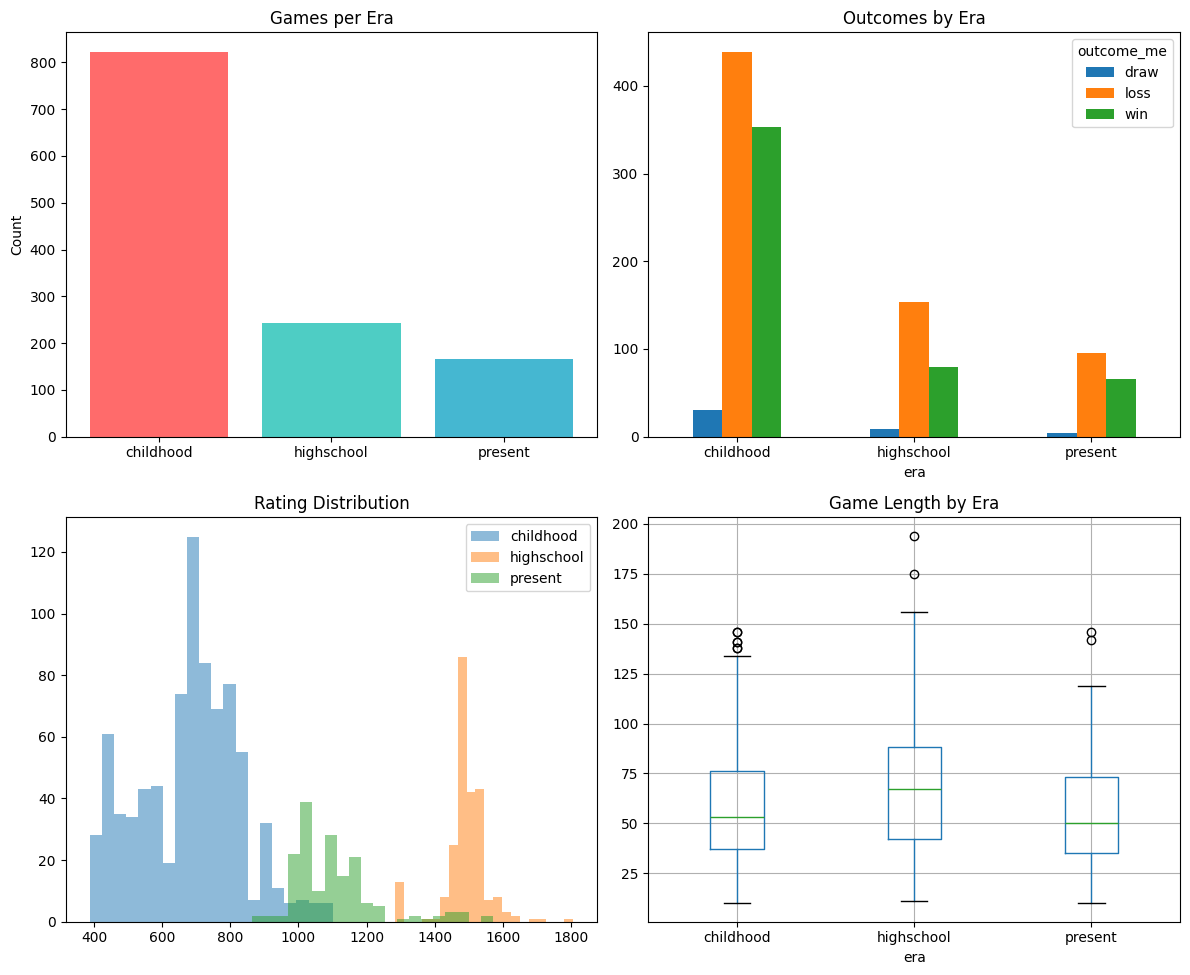

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

era_counts = df_features['era'].value_counts()
axes[0, 0].bar(era_counts.index, era_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Games per Era'); axes[0, 0].set_ylabel('Count')

outcome_era = df_features.groupby(['era', 'outcome_me']).size().unstack(fill_value=0)
outcome_era.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Outcomes by Era'); axes[0, 1].tick_params(axis='x', rotation=0)

for era in ['childhood', 'highschool', 'present']:
    data = df_features[df_features['era'] == era]['me_elo'].dropna()
    if len(data) > 0: axes[1, 0].hist(data, alpha=0.5, label=era, bins=20)
axes[1, 0].set_title('Rating Distribution'); axes[1, 0].legend()

df_features.boxplot(column='n_plies', by='era', ax=axes[1, 1])
axes[1, 1].set_title('Game Length by Era'); plt.suptitle('')
plt.tight_layout(); plt.show()

In [74]:
feature_cols = ['my_castled_by_N', 'my_queen_moved_by_N', 'my_pawn_moves_N', 
                'my_minor_moves_N', 'my_captures_N', 'my_checks_N']
print("Feature Means by Era:")
print(df_features.groupby('era')[feature_cols].mean().round(3))

Feature Means by Era:
            my_castled_by_N  my_queen_moved_by_N  my_pawn_moves_N  \
era                                                                 
childhood             0.174                0.531            4.200   
highschool            0.401                0.483            3.595   
present               0.235                0.602            3.735   

            my_minor_moves_N  my_captures_N  my_checks_N  
era                                                       
childhood              4.252          1.859        0.248  
highschool             4.773          1.793        0.240  
present                4.349          1.940        0.337  


---
## Next Steps

Data is cleaned and features extracted. Ready for:
1. Train/Test Split
2. Model Selection & Training
3. Evaluation

---

## Data Sources & References

### Chess.com Profile Data

This analysis uses data from two Chess.com accounts representing different periods of my chess journey:

#### Childhood Account: [Abdulrahmansoli](https://www.chess.com/member/Abdulrahmansoli)

| Attribute | Value |
|-----------|-------|
| **Username** | abdulrahmansoli |
| **Player ID** | 63375042 |
| **Country** | Egypt 🇪🇬 |
| **Status** | Basic |
| **League** | Crystal |
| **Joined** | July 2019 |
| **Followers** | 6 |

**Rating Statistics:**

| Time Control | Current | Best | Record (W/L/D) |
|--------------|---------|------|----------------|
| Rapid | 815 | 1101 | 76/79/6 |
| Blitz | 654 | 835 | 298/365/26 |
| Bullet | 467 | 812 | 29/50/0 |
| Daily | 397 | - | 0/2/0 |

**Archive Coverage:** 29 monthly archives from July 2019 to December 2025

---

#### Current Account: [AbdulrahmanSoliman2](https://www.chess.com/member/AbdulrahmanSoliman2)

| Attribute | Value |
|-----------|-------|
| **Username** | abdulrahmansoliman2 |
| **Player ID** | 78015894 |
| **Country** | Egypt 🇪🇬 |
| **Status** | Premium |
| **League** | Crystal |
| **Joined** | April 2020 |
| **Followers** | 1 |

**Rating Statistics:**

| Time Control | Current | Best | Record (W/L/D) |
|--------------|---------|------|----------------|
| Rapid | 1003 | 1308 | 55/69/4 |
| Blitz | 864 | 1573 | 11/29/0 |
| Bullet | 964 | - | 0/1/0 |

**Tactics Rating:** 1344 (highest)

**Archive Coverage:** 5 monthly archives from April 2020 to February 2026

---

### API References

Data was retrieved using the [Chess.com Public API](https://www.chess.com/news/view/published-data-api):

- Player Profile: `https://api.chess.com/pub/player/{username}`
- Player Stats: `https://api.chess.com/pub/player/{username}/stats`
- Game Archives: `https://api.chess.com/pub/player/{username}/games/archives`

*Data retrieved: February 13, 2026*